In [37]:
"""
CF-PDE system on a ciruclar domain
Model is:

ct = bete*w/(b + w)*c*(1-c-f) - dc*c + Dc Lap(c)
ft = beta(1 - w/(b + w))*f*(1-c-f) - df*f + Df Lap(f)
wt = lambda - mu*w - eta*c*w + Dw Lap(w)

Want to have Dirichlet BC for oxygen and no-flow
for c and f

"""

from __future__ import print_function
from fenics import *
from mshr import *
from dolfin import *
import numpy as np
import sys

T = 20.0            # final time
num_steps = 1000    # number of time steps
dt = T / num_steps # time step size
k = Constant(dt)

# CF params
beta = 5.0
b = 1.
n = 1.0
dc = 0.1
df = 0.1
q = 0.5
eta = .5
Dc = 4e-6
Df = 4e-4
Dw = 0.5e-1
w_r = 1.0

beta = Constant(beta)
b = Constant(b)
n = Constant(n)
dc = Constant(dc)
df = Constant(df)
q = Constant(q)
eta = Constant(eta)
Dc = Constant(Dc)
Df = Constant(Df)
Dw = Constant(Dw)
w_r = Constant(w_r)

# Read mesh from file
# mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')
L = 3.8
# L = float(sys.argv[1])
nx = ny = 30
# mesh = RectangleMesh(Point(-L, -L), Point(L, L), nx, ny)
domain = Circle(Point(0, 0), L)
mesh = generate_mesh(domain, nx)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define boundary condition for oxygen
def boundary(x, on_boundary):
    return on_boundary

# v.sub(2) puts a dirichlet BC only on the
# third component (oxygen)
bc = DirichletBC(V.sub(2), w_r, boundary)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
u = Function(V)
u_n = Function(V)

# Guasian ICs for C and F
u_0 = Expression(('0.4*exp(-1*pow(x[0], 2) - 1*pow(x[1], 2))','0.2*exp(-1*pow(x[0], 2) - 1*pow(x[1], 2))','1.0'), degree = 2, L=L)
u_n = interpolate(u_0, V)

# # Constant initial conditions for checking against ODE
# u_0 = Expression(('0.4','0.3','0.1'), degree = 2)
# u_n = interpolate(u_0, V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)


# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx  \
  + Dc*dot(grad(u_1), grad(v_1))*dx - (beta/( b + u_3 ))*u_3*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
  + ((u_2 - u_n2) / k)*v_2*dx  \
  + Df*dot(grad(u_2), grad(v_2))*dx - beta*(1 - u_3/( b + u_3 ))*u_2*(1-u_1-u_2)*v_2*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  \
  + ((u_3 - u_n3) / k)*v_3*dx  \
  + Dw*dot(grad(u_3), grad(v_3))*dx + eta*u_1*u_3*v_3*dx

# # Define variational problem
# F = ((u_1 - u_n1) / k)*v_1*dx  \
#   + Dc*dot(grad(u_1), grad(v_1))*dx - (pow(beta,n)/( pow(b,n) + pow(u_3,n) ))*pow(u_3,n)*u_1*(1-u_1-u_2)*v_1*dx + dc*u_1*v_1*dx  \
#   + ((u_2 - u_n2) / k)*v_2*dx  \
#   + Df*dot(grad(u_2), grad(v_2))*dx + df*u_2*v_2*dx + q*u_2*u_3*v_2*dx  - pow(beta,n)*(1 - pow(u_3,n)/( pow(b,n) + pow(u_3,n) ))*u_2*(1-u_1-u_2)*v_2*dx  \
#   + ((u_3 - u_n3) / k)*v_3*dx  \
#   + Dw*dot(grad(u_3), grad(v_3))*dx - _lambda*v_3*dx + mu*u_3*v_3*dx + eta*u_1*u_3*v_3*dx



# Create VTK files for visualization output
vtkfile_u_1 = File('cf_sys/u_1.pvd')
vtkfile_u_2 = File('cf_sys/u_2.pvd')
vtkfile_u_3 = File('cf_sys/u_3.pvd')

# Create progress bar
# progress = Progress('Time-stepping')
# set_log_level(PROGRESS)
progress = Progress('Time-stepping', num_steps)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    # timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u, bc)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)

    # Update previous solution
    u_n.assign(u)

    # Update progress bar
    set_log_level(LogLevel.PROGRESS)
    progress += 1

# Hold plot
#interactive()

### write out function values for anaerobic population
u_1, u_2, u_3 = split(u)

# outfile = open('cf_sys/u out.txt','w')
      
# outfile.close()

  Time-stepping [=====================================================] 100.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.624e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.262e-01 (tol = 1.000e-10) r (rel) = 3.415e-03 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 7.596e-05 (tol = 1.000e-10) r (rel) = 1.147e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 3: r (abs) = 2.297e-11 (to

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.591e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.528e-05 (tol = 1.000e-10) r (rel) = 4.103e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.384e-11 (tol = 1.000e-10) r (rel) = 8.702e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.610e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.770e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.090e-05 (tol = 1.000e-10) r (rel) = 4.005e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.487e-11 (tol = 1.000e-10) r (rel) = 8.400e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=>                                                   ] 2.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.787e-01 (tol = 1.000e-10) r (rel)

  Time-stepping [=>                                                   ] 3.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.943e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.579e-05 (tol = 1.000e-10) r (rel) = 3.901e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.581e-11 (tol = 1.000e-10) r (rel) = 8.140e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Ja

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.090e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.942e-05 (tol = 1.000e-10) r (rel) = 3.800e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.650e-11 (tol = 1.000e-10) r (rel) = 7.896e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.102e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.214e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.193e-05 (tol = 1.000e-10) r (rel) = 3.700e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.690e-11 (tol = 1.000e-10) r (rel) = 7.631e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.225e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.320e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.377e-05 (tol = 1.000e-10) r (rel) = 3.611e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.717e-11 (tol = 1.000e-10) r (rel) = 7.401e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.413e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.548e-05 (tol = 1.000e-10) r (rel) = 3.542e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.748e-11 (tol = 1.000e-10) r (rel) = 7.242e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.421e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  Time-stepping [====>                                                ] 8.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.490e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.718e-05 (tol = 1.000e-10) r (rel) = 3.501e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.780e-11 (tol = 1.000e-10) r (rel) = 7.147e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Ja

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.561e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.898e-05 (tol = 1.000e-10) r (rel) = 3.475e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.819e-11 (tol = 1.000e-10) r (rel) = 7.104e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.567e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.636e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.084e-05 (tol = 1.000e-10) r (rel) = 3.447e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.858e-11 (tol = 1.000e-10) r (rel) = 7.048e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.688e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.177e-05 (tol = 1.000e-10) r (rel) = 3.414e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.866e-11 (tol = 1.000e-10) r (rel) = 6.942e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.693e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.735e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.223e-05 (tol = 1.000e-10) r (rel) = 3.372e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.863e-11 (tol = 1.000e-10) r (rel) = 6.811e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.770e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.242e-05 (tol = 1.000e-10) r (rel) = 3.336e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.858e-11 (tol = 1.000e-10) r (rel) = 6.707e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=======>                                             ] 14.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.804e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.266e-05 (tol = 1.000e-10) r (rel) = 3.305e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.851e-11 (tol = 1.000e-10) r (rel) = 6.600e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.835e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.315e-05 (tol = 1.000e-10) r (rel) = 3.286e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.854e-11 (tol = 1.000e-10) r (rel) = 6.541e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.838e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.869e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.394e-05 (tol = 1.000e-10) r (rel) = 3.275e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.858e-11 (tol = 1.000e-10) r (rel) = 6.478e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.872e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.897e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.475e-05 (tol = 1.000e-10) r (rel) = 3.271e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.866e-11 (tol = 1.000e-10) r (rel) = 6.441e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=========>                                           ] 18.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.923e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.560e-05 (tol = 1.000e-10) r (rel) = 3.270e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.875e-11 (tol = 1.000e-10) r (rel) = 6.413e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==========>                                          ] 19.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.947e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.630e-05 (tol = 1.000e-10) r (rel) = 3.267e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.880e-11 (tol = 1.000e-10) r (rel) = 6.377e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.963e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.637e-05 (tol = 1.000e-10) r (rel) = 3.253e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.871e-11 (tol = 1.000e-10) r (rel) = 6.316e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===========>                                         ] 21.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.967e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.571e-05 (tol = 1.000e-10) r (rel) = 3.226e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.838e-11 (tol = 1.000e-10) r (rel) = 6.196e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [============>                                        ] 22.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.967e-01 (tol = 1.000e-10) r (rel

    Newton iteration 0: r (abs) = 2.962e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.472e-05 (tol = 1.000e-10) r (rel) = 3.197e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.797e-11 (tol = 1.000e-10) r (rel) = 6.067e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [============>                                        ] 23.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.961e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solvi

    Newton iteration 0: r (abs) = 2.948e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.402e-05 (tol = 1.000e-10) r (rel) = 3.189e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.775e-11 (tol = 1.000e-10) r (rel) = 6.021e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.946e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Kry

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.916e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.425e-05 (tol = 1.000e-10) r (rel) = 3.232e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.785e-11 (tol = 1.000e-10) r (rel) = 6.121e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.864e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.464e-05 (tol = 1.000e-10) r (rel) = 3.305e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.862e-11 (tol = 1.000e-10) r (rel) = 6.502e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.856e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.766e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.291e-05 (tol = 1.000e-10) r (rel) = 3.360e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.931e-11 (tol = 1.000e-10) r (rel) = 6.982e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.583e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.533e-05 (tol = 1.000e-10) r (rel) = 3.303e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.854e-11 (tol = 1.000e-10) r (rel) = 7.175e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.562e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.345e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.221e-05 (tol = 1.000e-10) r (rel) = 3.080e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.580e-11 (tol = 1.000e-10) r (rel) = 6.739e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [================>                                    ] 30.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.318e-01 (tol = 1.000e-10) r (rel

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 2.026e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.287e-05 (tol = 1.000e-10) r (rel) = 2.609e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.018e-11 (tol = 1.000e-10) r (rel) = 5.022e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.996e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.695e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.323e-05 (tol = 1.000e-10) r (rel) = 1.961e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 4.547e-12 (tol = 1.000e-10) r (rel) = 2.683e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=================>                                   ] 32.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.424e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.920e-05 (tol = 1.000e-10) r (rel) = 1.348e-04 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.627e-12 (tol = 1.000e-10) r (rel) = 1.142e-11 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.400e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.167e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.745e-06 (tol = 1.000e-10) r (rel) = 7.495e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 3.810e-13 (tol = 1.000e-10) r (rel) = 3.266e-12 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==================>                                  ] 34.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 9.848e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.663e-06 (tol = 1.000e-10) r (rel) = 3.719e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.052e-13 (tol = 1.000e-10) r (rel) = 1.068e-12 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==================>                                  ] 35.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 8.706e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.703e-06 (tol = 1.000e-10) r (rel) = 1.956e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 4.386e-14 (tol = 1.000e-10) r (rel) = 5.038e-13 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 8.622e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 7.916e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.007e-06 (tol = 1.000e-10) r (rel) = 1.272e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.001e-14 (tol = 1.000e-10) r (rel) = 2.527e-13 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 7.327e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.994e-07 (tol = 1.000e-10) r (rel) = 1.091e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 8.820e-15 (tol = 1.000e-10) r (rel) = 1.204e-13 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [====================>                                ] 39.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.959e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.316e-07 (tol = 1.000e-10) r (rel) = 1.051e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 4.493e-15 (tol = 1.000e-10) r (rel) = 6.457e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.728e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.889e-07 (tol = 1.000e-10) r (rel) = 1.024e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.782e-15 (tol = 1.000e-10) r (rel) = 4.134e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.709e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Time-stepping [======================>                              ] 42.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.547e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.461e-07 (tol = 1.000e-10) r (rel) = 9.868e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.062e-15 (tol = 1.000e-10) r (rel) = 3.150e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Time-stepping [=======================>                             ] 43.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.457e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.173e-07 (tol = 1.000e-10) r (rel) = 9.560e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.850e-15 (tol = 1.000e-10) r (rel) = 2.866e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.407e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.960e-07 (tol = 1.000e-10) r (rel) = 9.303e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.706e-15 (tol = 1.000e-10) r (rel) = 2.663e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.404e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.387e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.826e-07 (tol = 1.000e-10) r (rel) = 9.122e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.750e-15 (tol = 1.000e-10) r (rel) = 2.740e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [========================>                            ] 45.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.392e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.804e-07 (tol = 1.000e-10) r (rel) = 9.079e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.744e-15 (tol = 1.000e-10) r (rel) = 2.728e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.413e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.890e-07 (tol = 1.000e-10) r (rel) = 9.185e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.746e-15 (tol = 1.000e-10) r (rel) = 2.723e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=========================>                           ] 47.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.415e-02 (tol = 1.000e-10) r (rel

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.442e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.076e-07 (tol = 1.000e-10) r (rel) = 9.432e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.737e-15 (tol = 1.000e-10) r (rel) = 2.696e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.470e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.311e-07 (tol = 1.000e-10) r (rel) = 9.755e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.718e-15 (tol = 1.000e-10) r (rel) = 2.656e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.473e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.497e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.588e-07 (tol = 1.000e-10) r (rel) = 1.014e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.795e-15 (tol = 1.000e-10) r (rel) = 2.763e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.519e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.880e-07 (tol = 1.000e-10) r (rel) = 1.055e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.746e-15 (tol = 1.000e-10) r (rel) = 2.678e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.521e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Time-stepping [===========================>                         ] 52.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.535e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.163e-07 (tol = 1.000e-10) r (rel) = 1.096e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.839e-15 (tol = 1.000e-10) r (rel) = 2.814e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.544e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.435e-07 (tol = 1.000e-10) r (rel) = 1.136e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.853e-15 (tol = 1.000e-10) r (rel) = 2.831e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [============================>                        ] 54.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.542e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.657e-07 (tol = 1.000e-10) r (rel) = 1.171e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.922e-15 (tol = 1.000e-10) r (rel) = 2.938e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=============================>                       ] 55.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.528e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.774e-07 (tol = 1.000e-10) r (rel) = 1.191e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.965e-15 (tol = 1.000e-10) r (rel) = 3.009e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.526e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.506e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.800e-07 (tol = 1.000e-10) r (rel) = 1.199e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.025e-15 (tol = 1.000e-10) r (rel) = 3.112e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.468e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.732e-07 (tol = 1.000e-10) r (rel) = 1.195e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.034e-15 (tol = 1.000e-10) r (rel) = 3.144e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.423e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.579e-07 (tol = 1.000e-10) r (rel) = 1.180e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.993e-15 (tol = 1.000e-10) r (rel) = 3.103e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===============================>                     ] 59.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.374e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.375e-07 (tol = 1.000e-10) r (rel) = 1.157e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 2.040e-15 (tol = 1.000e-10) r (rel) = 3.200e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [================================>                    ] 60.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.369e-02 (tol = 1.000e-10) r (rel

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.319e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.120e-07 (tol = 1.000e-10) r (rel) = 1.127e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.938e-15 (tol = 1.000e-10) r (rel) = 3.067e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.314e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (to

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.259e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.825e-07 (tol = 1.000e-10) r (rel) = 1.091e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.955e-15 (tol = 1.000e-10) r (rel) = 3.123e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=================================>                   ] 62.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.193e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.502e-07 (tol = 1.000e-10) r (rel) = 1.050e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.898e-15 (tol = 1.000e-10) r (rel) = 3.065e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=================================>                   ] 63.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.186e-02 (tol = 1.000e-10) r (rel

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.124e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 6.162e-07 (tol = 1.000e-10) r (rel) = 1.006e-05 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.877e-15 (tol = 1.000e-10) r (rel) = 3.066e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==================================>                  ] 64.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 6.051e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.813e-07 (tol = 1.000e-10) r (rel) = 9.607e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.753e-15 (tol = 1.000e-10) r (rel) = 2.897e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==================================>                  ] 65.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.976e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.464e-07 (tol = 1.000e-10) r (rel) = 9.144e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.784e-15 (tol = 1.000e-10) r (rel) = 2.986e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===================================>                 ] 66.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.899e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 5.121e-07 (tol = 1.000e-10) r (rel) = 8.682e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.708e-15 (tol = 1.000e-10) r (rel) = 2.896e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.891e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.820e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 4.789e-07 (tol = 1.000e-10) r (rel) = 8.228e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.776e-15 (tol = 1.000e-10) r (rel) = 3.053e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [====================================>                ] 68.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.732e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 4.439e-07 (tol = 1.000e-10) r (rel) = 7.745e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.722e-15 (tol = 1.000e-10) r (rel) = 3.004e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.724e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.643e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 4.110e-07 (tol = 1.000e-10) r (rel) = 7.284e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.716e-15 (tol = 1.000e-10) r (rel) = 3.041e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=====================================>               ] 70.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.635e-02 (tol = 1.000e-10) r (rel

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.554e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.803e-07 (tol = 1.000e-10) r (rel) = 6.847e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.685e-15 (tol = 1.000e-10) r (rel) = 3.034e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.546e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.464e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.518e-07 (tol = 1.000e-10) r (rel) = 6.437e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.655e-15 (tol = 1.000e-10) r (rel) = 3.028e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [======================================>              ] 73.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.456e-02 (tol = 1.000e-10) r (rel

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.383e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.277e-07 (tol = 1.000e-10) r (rel) = 6.088e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.672e-15 (tol = 1.000e-10) r (rel) = 3.106e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=======================================>             ] 74.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.303e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 3.054e-07 (tol = 1.000e-10) r (rel) = 5.760e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.712e-15 (tol = 1.000e-10) r (rel) = 3.228e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=======================================>             ] 75.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.295e-02 (tol = 1.000e-10) r (rel

  Time-stepping [========================================>            ] 76.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.214e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.829e-07 (tol = 1.000e-10) r (rel) = 5.425e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.685e-15 (tol = 1.000e-10) r (rel) = 3.231e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.134e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.640e-07 (tol = 1.000e-10) r (rel) = 5.141e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.697e-15 (tol = 1.000e-10) r (rel) = 3.304e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Time-stepping [=========================================>           ] 78.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 5.055e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.465e-07 (tol = 1.000e-10) r (rel) = 4.876e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.636e-15 (tol = 1.000e-10) r (rel) = 3.237e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.969e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.289e-07 (tol = 1.000e-10) r (rel) = 4.606e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.729e-15 (tol = 1.000e-10) r (rel) = 3.480e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.884e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 2.127e-07 (tol = 1.000e-10) r (rel) = 4.356e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.733e-15 (tol = 1.000e-10) r (rel) = 3.548e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.876e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.807e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.993e-07 (tol = 1.000e-10) r (rel) = 4.145e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.706e-15 (tol = 1.000e-10) r (rel) = 3.550e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  Time-stepping [===========================================>         ] 82.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.716e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.844e-07 (tol = 1.000e-10) r (rel) = 3.911e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.683e-15 (tol = 1.000e-10) r (rel) = 3.569e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Time-stepping [============================================>        ] 83.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.641e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.731e-07 (tol = 1.000e-10) r (rel) = 3.730e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.667e-15 (tol = 1.000e-10) r (rel) = 3.591e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Time-stepping [============================================>        ] 84.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.552e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.606e-07 (tol = 1.000e-10) r (rel) = 3.528e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.720e-15 (tol = 1.000e-10) r (rel) = 3.778e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.472e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.501e-07 (tol = 1.000e-10) r (rel) = 3.357e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.727e-15 (tol = 1.000e-10) r (rel) = 3.861e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [=============================================>       ] 85.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    New

  Time-stepping [==============================================>      ] 86.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.393e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.405e-07 (tol = 1.000e-10) r (rel) = 3.198e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.669e-15 (tol = 1.000e-10) r (rel) = 3.799e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.315e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.316e-07 (tol = 1.000e-10) r (rel) = 3.050e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.692e-15 (tol = 1.000e-10) r (rel) = 3.921e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [==============================================>      ] 88.0%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.308e-02 (tol = 1.000e-10) r (rel

    Newton iteration 0: r (abs) = 4.231e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.227e-07 (tol = 1.000e-10) r (rel) = 2.900e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.693e-15 (tol = 1.000e-10) r (rel) = 4.001e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.224e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Kry

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.155e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.152e-07 (tol = 1.000e-10) r (rel) = 2.772e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.703e-15 (tol = 1.000e-10) r (rel) = 4.098e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.149e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 4.081e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.082e-07 (tol = 1.000e-10) r (rel) = 2.652e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.770e-15 (tol = 1.000e-10) r (rel) = 4.336e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [================================================>    ] 91.4%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Time-stepping [=================================================>   ] 92.6%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.995e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 1.007e-07 (tol = 1.000e-10) r (rel) = 2.521e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.717e-15 (tol = 1.000e-10) r (rel) = 4.298e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.923e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 9.482e-08 (tol = 1.000e-10) r (rel) = 2.417e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.711e-15 (tol = 1.000e-10) r (rel) = 4.362e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.916e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Time-stepping [==================================================>  ] 94.8%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.852e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.937e-08 (tol = 1.000e-10) r (rel) = 2.320e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.700e-15 (tol = 1.000e-10) r (rel) = 4.413e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.776e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 8.387e-08 (tol = 1.000e-10) r (rel) = 2.221e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.704e-15 (tol = 1.000e-10) r (rel) = 4.512e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 

  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.708e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.920e-08 (tol = 1.000e-10) r (rel) = 2.136e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.763e-15 (tol = 1.000e-10) r (rel) = 4.754e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  Time-stepping [===================================================> ] 97.2%
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain J

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.647e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.524e-08 (tol = 1.000e-10) r (rel) = 2.063e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.727e-15 (tol = 1.000e-10) r (rel) = 4.736e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.641e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.581e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 1: r (abs) = 7.116e-08 (tol = 1.000e-10) r (rel) = 1.987e-06 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 (PETSc LU solver, umfpack).
    PETSc Krylov solver starting to solve 5631 x 5631 system.
    Newton iteration 2: r (abs) = 1.731e-15 (tol = 1.000e-10) r (rel) = 4.833e-14 (tol = 1.000e-09)
    Newton solver finished in 2 iterations and 2 linear solver iterations.
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 3.575e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Solving linear system of size 5631 x 5631 

  Object cannot be plotted directly, projecting to piecewise linears.
  Solving linear system of size 1877 x 1877 (PETSc LU solver, umfpack).
  PETSc Krylov solver starting to solve 1877 x 1877 system.


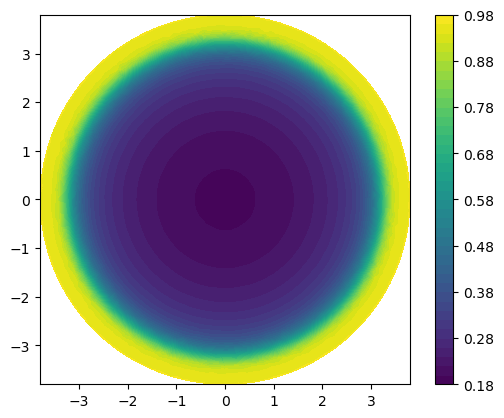

In [48]:
import matplotlib.pyplot as plt
fig = plot(u[0])
plt.colorbar(fig)

In [15]:
dt

0.02

In [53]:
c = u[0]
f = u[1]

In [24]:
f([0,0])

0.7753876173399816

mesh

In [43]:
dir(mesh)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_repr_html_',
 '_repr_svg_',
 '_ufl_domain',
 'bounding_box_tree',
 'cell_name',
 'cell_orientations',
 'cells',
 'color',
 'coordinates',
 'data',
 'domains',
 'geometric_dimension',
 'geometry',
 'hash',
 'hmax',
 'hmin',
 'id',
 'init',
 'init_cell_orientations',
 'init_global',
 'label',
 'mpi_comm',
 'name',
 'num_cells',
 'num_edges',
 'num_entities',
 'num_entities_global',
 'num_faces',
 'num_facets',
 'num_vertices',
 'order',
 'ordered',
 'parameters',
 'rename',
 'rmax',
 'rmin',
 'rotate',
 'scale',
 'smooth',
 'smooth_boundary',
 'snap_boundary',
 'topology',
 'translate',
 'type',
 'ufl_cell',
 'ufl_coordinate_element',
 '

In [44]:
V = FunctionSpace(mesh, "CG", 2)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [18]:
V
dof_coordinates = V.tabulate_dof_coordinates()

In [19]:
dof_coordinates

array([[ 2.79374726,  0.18701937],
       [ 2.79374726,  0.18701937],
       [ 2.79374726,  0.18701937],
       ...,
       [-2.79374726,  0.18701937],
       [-2.79374726,  0.18701937],
       [-2.79374726,  0.18701937]])

In [51]:
uh = Function(V)
expr = u[2]

In [54]:
xyz = V.tabulate_dof_coordinates()

In [55]:
x = xyz[:,0]

In [16]:
f0 = f([0,0])
f0

0.7753876173399816

In [59]:
f0 > 0

True

In [60]:
tol = 1e-3

In [61]:
f0 > tol

False

In [45]:
u[2]([0,0])

0.009633973305140115

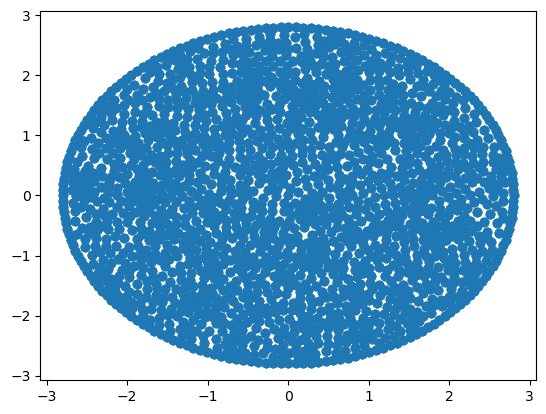

In [60]:
plt.scatter(dof_coordinates[:,0],dof_coordinates[:,1])

In [41]:
dof_coordinates[:,0]

array([ 2.79374726,  2.79374726,  2.79374726, ..., -2.79374726,
       -2.79374726, -2.79374726])

In [42]:
u[1](dof_coordinates[55])

  Computed bounding box tree with 7127 nodes for 3564 entities.


0.6645594697646656

In [58]:
dof_coordinates[1]

array([2.79374726, 0.18701937])

In [44]:
u[1]([0,0])

0.7777502730786279

In [49]:
L

3.8

In [55]:
c([3.8,0])

0.9616330294405453

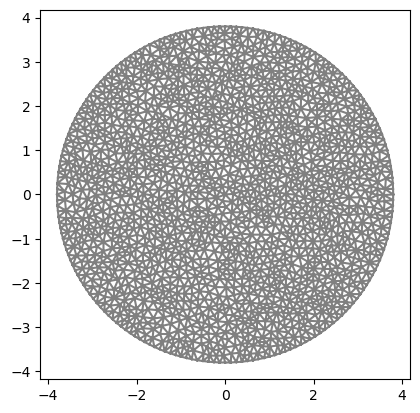

In [61]:
plot(mesh)